In [1]:
## data.py
import pandas as pd
import numpy as np
import torch

In [2]:
print(torch.__version__)

2.6.0.dev20241112+cu121


In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
def sample_interior(
    n_samples: int,
    x_range: tuple = (0, 1),
    y_range: tuple = (0, 1),
    device :  str = 'cpu'
) -> torch.Tensor:
    """ 
    Sample points in the interior of the domain.
    Args:
        n_samples(int) : Number of samples to be drawn.
        x_range(tuple) : Range of x values.
        y_range(tuple) : Range of y values.
        Returns:
            torch.Tensor : Sampled points of shape (n_samples, 2).
    """
    x_samples = np.random.uniform(x_range[0], x_range[1], n_samples)
    y_samples = np.random.uniform(y_range[0], y_range[1], n_samples)
    samples = np.stack((x_samples, y_samples), axis=1)
    return torch.tensor(samples,dtype= torch.float32).to(device=device)

def sample_boundary(
    n_samples : int,
    x_range: tuple = (0, 1),
    y_range: tuple = (0, 1),
    device :  str = 'cpu'
) -> torch.Tensor:
    #! we'll consider only 0-1,0-1
    """ 
    Sample points and normal vectors on the boundary of the domain.
    Args :
        n_samples_per_edge(int) : Number of samples to be drawn per edge.
        x_range(tuple) : Range of x values.
        y_range(tuple) : Range of y values.

    Returns:
        torch.Tensor : Sampled points of shape (n_samples, 2).
        torch.Tensor : Normal vectors of shape (n_samples, 2).
    """
    n_samples_per_edge = n_samples // 4
    t = np.linspace(0,1,n_samples_per_edge)    
    # Four edges 
    left   = np.stack([np.zeros_like(t), t], axis=1)
    right  = np.stack([np.ones_like(t), t], axis=1)
    bottom = np.stack([t, np.zeros_like(t)], axis=1)
    top    = np.stack([t, np.ones_like(t)], axis=1)
    
    # stack all edge 
    pts = np.vstack([left, right, bottom, top])
    
    # normal vectors
    normals = np.vstack([
        np.tile(np.array([-1, 0]), (n_samples_per_edge, 1)),  # left
        np.tile(np.array([1, 0]), (n_samples_per_edge, 1)),   # right
        np.tile(np.array([0, -1]), (n_samples_per_edge, 1)),  # bottom
        np.tile(np.array([0, 1]), (n_samples_per_edge, 1))     # top
    ])
    
    return (
        torch.tensor(pts,dtype = torch.float32).to(device=device),
        torch.tensor(normals,dtype = torch.float32).to(device=device)
    )
def generate_pts(n_interior : int = 1000, n_boundary : int = 500, device :str = 'cpu'):
    interior_pts = sample_interior(n_interior,device = device)
    boundary_pts,normals = sample_boundary(n_boundary,device = device)
    return interior_pts,boundary_pts,normals
    

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [98]:
class U_FCN(nn.Module):
    def __init__(self,in__features : int = 2, out_features : int = 1, hidden_dims : list = [8,16,32,32,16,8]):
        super(U_FCN,self).__init__()
        layers = []
        input_dim = in__features
        for h_dim in hidden_dims:
            # layers.append(nn.BatchNorm1d(input_dim))
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.Tanh())
            # layers.append(nn.Dropout(p=0.2))
            input_dim = h_dim
        layers.append(nn.Linear(input_dim, out_features))
        self.network = nn.Sequential(*layers)
    def forward(self,x):
        return self.network(x)
    
# ---------------biharmonic operator ---------------

def biharmonic_operator(u : torch.Tensor,x : torch.Tensor):
    """
    Compute Δ²u = Laplacian(Laplacian(u)) using autograd.
    x : torch.Tensor (N,2) with required_grad = True
    return : torch.Tensor (N,1)
    """
    if not x.requires_grad:
        x.requires_grad = True
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    u_x = grad_u[:,0:1]
    u_y = grad_u[:,1:2]
    u_xx = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x),create_graph=True)[0][:,0:1]
    u_yy = torch.autograd.grad(u_y,x,grad_outputs=torch.ones_like(u_y),create_graph=True)[0][:,1:2]
    lap_u = u_xx + u_yy
    
    grad_lap_u = torch.autograd.grad(lap_u,x,grad_outputs=torch.ones_like(lap_u),create_graph=True)[0]
    lap_u_x = grad_lap_u[:,0:1]
    lap_u_y = grad_lap_u[:,1:2]
    lap_u_xx = torch.autograd.grad(lap_u_x,x,grad_outputs=torch.ones_like(lap_u_x),create_graph=True)[0][:,0:1]
    lap_u_yy = torch.autograd.grad(lap_u_y,x,grad_outputs=torch.ones_like(lap_u_y),create_graph=True)[0][:,1:2]
    
    return lap_u_xx + lap_u_yy


### first order normal derivative
$$
\frac{\partial u}{\partial n} \;=\; \nabla u \cdot \mathbf{n}
$$

### second order normal derivative
$$
\frac{\partial^2 u}{\partial n^2} \;=\; \mathbf{n}^\top H_u\,\mathbf{n}
$$

### equivalent chain rule form 
$$
\frac{\partial^2 u}{\partial n^2}
\;=\;
\mathbf{n}\cdot\nabla\!\big(\mathbf{n}\cdot\nabla u\big)
\;=\;
\mathbf{n}\cdot\nabla\!\Big(\frac{\partial u}{\partial n}\Big).
$$


In [99]:

def compute_second_normal_derivative(u: torch.Tensor, x: torch.Tensor, normal: torch.Tensor):
    """
    Compute the second normal derivative ∂²u/∂n² using autograd.
    u : torch.Tensor (N,1) with required_grad = True
    x : torch.Tensor (N,2)
    normal : torch.Tensor (N,2)
    return : torch.Tensor (N,1)
    """
    if not x.requires_grad:
        x.requires_grad = True
    
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    du_dn = torch.sum(grad_u * normal, dim=1, keepdim=True) #TODO we could use dot product here
    
    grad_du_dn = torch.autograd.grad(du_dn,x,grad_outputs=torch.ones_like(du_dn),create_graph=True)[0]
    d2u_dn2 = torch.sum(grad_du_dn * normal, dim=1, keepdim=True) #similarily
    
    return d2u_dn2
    

In [ ]:
def true_solution(pts):
    """ 
    pts : torch.Tensor with shape (N,2)
    """
    if not isinstance(pts,torch.Tensor):
        pts = torch.Tensor(pts,dtype = torch.float32)
    pts = pts.to(dtype=torch.float32, device=pts.device)
    C = 1.0/(2*torch.pi**2)
    sol = C * torch.sin(torch.pi*pts[:,0]) * torch.sin(torch.pi*pts[:,1])
     
    return sol.unsqueeze(-1)
def func(pts):
    """ 
    pts : torch.Tensor with shape (N,2)
    """
    if not isinstance(pts,torch.Tensor):
        pts = torch.Tensor(pts,dtype = torch.float32)
    pts = pts.to(dtype=torch.float32, device=pts.device)
    f =  2.0*torch.pi**2 * torch.sin(torch.pi* pts[:,0]) * torch.sin(torch.pi * pts[:,1])
    return f.unsqueeze(-1)

def _fucn_biharmonic(pts):
    """ 
    pts : torch.Tensor with shape (N,2)
    """
    if not isinstance(pts,torch.Tensor):
        pts = torch.Tensor(pts,dtype = torch.float32)
    pts = pts.clone().
    
    
    return f.unsqueeze(-1)
    

In [74]:
def g1(pts):
    """ 
    g1(pts) = u same as the neural apporximator
    """
    return true_solution(pts)

def g2(pts,normals):
    """ 
    g2(pts,normals) = d2u/dn2
    """
    u = true_solution(pts)
    return compute_second_normal_derivative(u,pts,normals)


In [75]:
from tqdm import tqdm

In [76]:
def pde_residual(model,pts):
    device = next(model.parameters()).device
    if not pts.requires_grad:
        pts.requires_grad_(True)
    
    u = model(pts)
    lap2_U = biharmonic_operator(u,pts)
    true_f = func(pts)
    return F.mse_loss(lap2_U,true_f)

def boundary_loss(model,pts,normals,lambda1 : int = 1.0, lambda2 : int = 5.0):
    device = next(model.parameters()).device
    if not pts.requires_grad:
        pts.requires_grad_(True)
    
    u = model(pts)
    d2u_dn2 = compute_second_normal_derivative(u,pts,normals)
    g1_vals = g1(pts)
    loss_g1 = F.mse_loss(u,g1_vals)
    g2_vals = g2(pts,normals)
    loss_g2 = F.mse_loss(d2u_dn2,g2_vals)
    return lambda1 * loss_g1 + lambda2 * loss_g2
    
    

In [77]:
def validate(model,n_interior:int = 1000, n_boundary : int = 500):
    eps = 1e-8
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        interior_pts,boundary_pts,_ = generate_pts(n_interior,n_boundary,device = device)
        pts = torch.cat((interior_pts,boundary_pts),dim = 0)
        u_pred = model(pts).detach().cpu().numpy()
        u_true = true_solution(pts).detach().cpu().numpy()
        rel = np.linalg.norm(u_pred - u_true)/(np.linalg.norm(u_true)+ eps) 
    return rel



        
        
    

In [78]:
def train1(
    model,
    optimizer,
    log_var_pde : torch.nn.Parameter,
    log_var_bndry : torch.nn.Parameter,
    epochs = 10000,
    n_interior : int = 5000,
    n_boundary : int = 1000,
    print_every = 50,
    save_dir = 'biharmonic_pinns' 
):
    losses = []
    pde_losses = []
    device = next(model.parameters()).device
    pbar = tqdm(range(1,epochs + 1),desc="epochs")
    for epoch in pbar:
        model.train()
        optimizer.zero_grad()
        
        interior_pts,boundary_pts,normals = generate_pts(n_interior=n_interior,n_boundary=n_boundary,device=device)
        interior_pts.requires_grad = True
        boundary_pts.requires_grad = True
        loss_pde = pde_residual(model,interior_pts)
        loss_bndry = boundary_loss(model,boundary_pts,normals)
        #! kendall uncertainity-weighting 
        loss = 0.5*(torch.exp(-log_var_pde)*loss_pde + log_var_pde)  + 0.5*(torch.exp(-log_var_bndry)*loss_bndry + log_var_bndry)
        loss.backward()
        optimizer.step() 
        with torch.no_grad():
            log_var_pde.clamp_(0.0, 5.0)
            log_var_bndry.clamp_(0.0, 5.0)
        losses.append(loss.item())
        pde_losses.append(loss_pde.item())
        pbar.set_description(f"Epoch {epoch}: Loss {loss.item():.6f}")
        pbar.set_postfix({'weight_pde': torch.exp(-log_var_pde).item(), 'weight_bndry': torch.exp(-log_var_bndry).item()})
        if epoch % (epochs // 10) == 0:
            # print({'Total Loss': loss.item(),'actual Pde Loss': loss_pde.item(), 'actual Boundary Loss': loss_bndry.item(), 'Val Rel Error': val_rel_error}) 
            save_path = f"{save_dir}/biharmonic_pinn_epoch{epoch}.pt"
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'log_var_pde': log_var_pde.detach().cpu(),
                'log_var_bndry': log_var_bndry.detach().cpu(),
            }, save_path)
            print(f"Saved to {save_path}")
        if epoch % print_every == 0:
            val_rel_error = validate(model,n_interior=1000,n_boundary=500)
            print({'Total Loss': f"{loss.item():.6f}",'actual Pde Loss': f"{loss_pde.item():.6f}", 'actual Boundary Loss': f"{loss_bndry.item():.6f}", 'Val Rel Error': val_rel_error}) 
    return losses, pde_losses
        
        
    

In [79]:
def train(
    model,
    optimizer,
    epochs = 10000,
    n_interior : int = 5000,
    n_boundary : int = 1000,
    print_every = 50):
    
    device = next(model.parameters()).device
    losses = []
    pde_losses = []
    pbar = tqdm(range(1,epochs + 1),desc="epochs")
    for epoch in pbar:
        model.train()
        optimizer.zero_grad()
        interior_pts,boundary_pts,normals = generate_pts(n_interior=n_interior,n_boundary=n_boundary,device=device)
        interior_pts.requires_grad = True
        boundary_pts.requires_grad = True
        loss_pde = pde_residual(model,interior_pts)
        loss_bndry = boundary_loss(model,boundary_pts,normals)
        loss = 5*loss_pde + loss_bndry
        loss.backward()
        optimizer.step() 

        losses.append(loss.item())
        pde_losses.append(loss_pde.item())
        pbar.set_description(f"Epoch {epoch}: Loss {loss.item():.6f}")
        if epoch % print_every == 0:
            val_rel_error = validate(model,n_interior=1000,n_boundary=500)
            pbar.set_postfix({'Total Loss': loss.item(),'Pde Loss': loss_pde.item(), 'Boundary Loss': loss_bndry.item(), 'Val Rel Error': val_rel_error})   
    
    return losses, pde_losses
        
        
    

In [80]:
import os 
os.makedirs('biharmonic_pinns',exist_ok=True)

In [81]:
model = U_FCN(in__features=2,out_features=1,hidden_dims=[16,32,64,128,128,64,32,16]).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
log_var_pde = torch.nn.Parameter(torch.tensor(0.0,device= device))
log_var_bndry = torch.nn.Parameter(torch.tensor(0.0,device= device))
optimizer.add_param_group({'params': [log_var_pde, log_var_bndry],'lr' : 1e-5})


In [83]:
checkpoint = torch.load(r'biharmonic_pinns_version2/biharmonic_pinn_epoch5000.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [84]:

losess,pde_losses = train1(
    model,
    optimizer,
    log_var_pde,
    log_var_bndry,
    epochs = 5000,
    n_interior = 5000,
    n_boundary = 1000,
    print_every = 100,
    save_dir = 'biharmonic_pinns_version2'
)

Epoch 101: Loss 0.013114:   2%|▏         | 100/5000 [00:22<16:45,  4.87it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.013215', 'actual Pde Loss': '0.025670', 'actual Boundary Loss': '0.000760', 'Val Rel Error': np.float32(0.39424497)}


Epoch 200: Loss 0.001863:   4%|▍         | 200/5000 [00:42<18:02,  4.44it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001863', 'actual Pde Loss': '0.003412', 'actual Boundary Loss': '0.000315', 'Val Rel Error': np.float32(0.5482233)}


Epoch 300: Loss 0.006590:   6%|▌         | 300/5000 [01:06<17:06,  4.58it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.006590', 'actual Pde Loss': '0.012772', 'actual Boundary Loss': '0.000408', 'Val Rel Error': np.float32(0.55547595)}


Epoch 400: Loss 0.009109:   8%|▊         | 400/5000 [01:34<19:08,  4.01it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.009109', 'actual Pde Loss': '0.017815', 'actual Boundary Loss': '0.000404', 'Val Rel Error': np.float32(0.51658803)}


Epoch 500: Loss 0.001508:  10%|█         | 500/5000 [01:56<15:53,  4.72it/s, weight_pde=1, weight_bndry=1]

Saved to biharmonic_pinns_version2/biharmonic_pinn_epoch500.pt
{'Total Loss': '0.001508', 'actual Pde Loss': '0.002698', 'actual Boundary Loss': '0.000319', 'Val Rel Error': np.float32(0.53870535)}


Epoch 601: Loss 0.001323:  12%|█▏        | 600/5000 [02:19<15:11,  4.83it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.002343', 'actual Pde Loss': '0.004364', 'actual Boundary Loss': '0.000321', 'Val Rel Error': np.float32(0.5479814)}


Epoch 700: Loss 0.004409:  14%|█▍        | 700/5000 [02:40<14:49,  4.84it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.004409', 'actual Pde Loss': '0.007969', 'actual Boundary Loss': '0.000849', 'Val Rel Error': np.float32(0.52673125)}


Epoch 801: Loss 0.001024:  16%|█▌        | 800/5000 [03:01<14:47,  4.73it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001139', 'actual Pde Loss': '0.001959', 'actual Boundary Loss': '0.000320', 'Val Rel Error': np.float32(0.5280651)}


Epoch 900: Loss 0.000838:  18%|█▊        | 900/5000 [03:24<16:45,  4.08it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000838', 'actual Pde Loss': '0.001401', 'actual Boundary Loss': '0.000276', 'Val Rel Error': np.float32(0.5519312)}


Epoch 1000: Loss 0.002099:  20%|██        | 1000/5000 [03:49<17:48,  3.74it/s, weight_pde=1, weight_bndry=1]

Saved to biharmonic_pinns_version2/biharmonic_pinn_epoch1000.pt
{'Total Loss': '0.002099', 'actual Pde Loss': '0.003933', 'actual Boundary Loss': '0.000264', 'Val Rel Error': np.float32(0.53190595)}


Epoch 1100: Loss 0.001251:  22%|██▏       | 1100/5000 [04:16<15:26,  4.21it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001251', 'actual Pde Loss': '0.002224', 'actual Boundary Loss': '0.000278', 'Val Rel Error': np.float32(0.514613)}


Epoch 1200: Loss 0.001862:  24%|██▍       | 1200/5000 [04:44<13:27,  4.70it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001862', 'actual Pde Loss': '0.003438', 'actual Boundary Loss': '0.000286', 'Val Rel Error': np.float32(0.54512507)}


Epoch 1301: Loss 0.001688:  26%|██▌       | 1300/5000 [05:12<13:37,  4.53it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.002219', 'actual Pde Loss': '0.004094', 'actual Boundary Loss': '0.000343', 'Val Rel Error': np.float32(0.48268858)}


Epoch 1400: Loss 0.003315:  28%|██▊       | 1400/5000 [05:38<14:13,  4.22it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.003315', 'actual Pde Loss': '0.006245', 'actual Boundary Loss': '0.000384', 'Val Rel Error': np.float32(0.44591615)}


Epoch 1500: Loss 0.003398:  30%|███       | 1500/5000 [06:04<14:12,  4.10it/s, weight_pde=1, weight_bndry=1]

Saved to biharmonic_pinns_version2/biharmonic_pinn_epoch1500.pt
{'Total Loss': '0.003398', 'actual Pde Loss': '0.006512', 'actual Boundary Loss': '0.000284', 'Val Rel Error': np.float32(0.44422233)}


Epoch 1601: Loss 0.001106:  32%|███▏      | 1600/5000 [06:25<11:25,  4.96it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001059', 'actual Pde Loss': '0.001835', 'actual Boundary Loss': '0.000283', 'Val Rel Error': np.float32(0.54703856)}


Epoch 1701: Loss 0.005752:  34%|███▍      | 1700/5000 [06:46<11:04,  4.96it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.003170', 'actual Pde Loss': '0.006017', 'actual Boundary Loss': '0.000323', 'Val Rel Error': np.float32(0.49580467)}


Epoch 1801: Loss 0.003625:  36%|███▌      | 1800/5000 [07:07<11:16,  4.73it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.003086', 'actual Pde Loss': '0.005756', 'actual Boundary Loss': '0.000417', 'Val Rel Error': np.float32(0.57008153)}


Epoch 1900: Loss 0.000551:  38%|███▊      | 1900/5000 [07:33<14:28,  3.57it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000551', 'actual Pde Loss': '0.000835', 'actual Boundary Loss': '0.000267', 'Val Rel Error': np.float32(0.50133395)}


Epoch 2000: Loss 0.004926:  40%|████      | 2000/5000 [08:01<14:49,  3.37it/s, weight_pde=1, weight_bndry=1]

Saved to biharmonic_pinns_version2/biharmonic_pinn_epoch2000.pt
{'Total Loss': '0.004926', 'actual Pde Loss': '0.009477', 'actual Boundary Loss': '0.000375', 'Val Rel Error': np.float32(0.4842181)}


Epoch 2100: Loss 0.002885:  42%|████▏     | 2100/5000 [08:28<14:21,  3.37it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.002885', 'actual Pde Loss': '0.005484', 'actual Boundary Loss': '0.000286', 'Val Rel Error': np.float32(0.43655327)}


Epoch 2200: Loss 0.017316:  44%|████▍     | 2200/5000 [08:54<13:29,  3.46it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.017316', 'actual Pde Loss': '0.034264', 'actual Boundary Loss': '0.000368', 'Val Rel Error': np.float32(0.5391768)}


Epoch 2300: Loss 0.003295:  46%|████▌     | 2300/5000 [09:22<12:22,  3.64it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.003295', 'actual Pde Loss': '0.006295', 'actual Boundary Loss': '0.000295', 'Val Rel Error': np.float32(0.4337468)}


Epoch 2400: Loss 0.007319:  48%|████▊     | 2400/5000 [09:48<13:45,  3.15it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.007319', 'actual Pde Loss': '0.014171', 'actual Boundary Loss': '0.000467', 'Val Rel Error': np.float32(0.6248462)}


Epoch 2500: Loss 0.002924:  50%|█████     | 2500/5000 [10:19<14:24,  2.89it/s, weight_pde=1, weight_bndry=1]

Saved to biharmonic_pinns_version2/biharmonic_pinn_epoch2500.pt
{'Total Loss': '0.002924', 'actual Pde Loss': '0.005568', 'actual Boundary Loss': '0.000279', 'Val Rel Error': np.float32(0.4766347)}


Epoch 2600: Loss 0.001521:  52%|█████▏    | 2600/5000 [10:44<09:00,  4.44it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001521', 'actual Pde Loss': '0.002732', 'actual Boundary Loss': '0.000309', 'Val Rel Error': np.float32(0.5197281)}


Epoch 2700: Loss 0.026596:  54%|█████▍    | 2700/5000 [11:09<08:55,  4.30it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.026596', 'actual Pde Loss': '0.052907', 'actual Boundary Loss': '0.000284', 'Val Rel Error': np.float32(0.58812934)}


Epoch 2800: Loss 0.000589:  56%|█████▌    | 2800/5000 [11:37<10:47,  3.40it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000589', 'actual Pde Loss': '0.000916', 'actual Boundary Loss': '0.000262', 'Val Rel Error': np.float32(0.5050075)}


Epoch 2901: Loss 0.003488:  58%|█████▊    | 2900/5000 [12:05<08:56,  3.91it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.002729', 'actual Pde Loss': '0.005164', 'actual Boundary Loss': '0.000293', 'Val Rel Error': np.float32(0.52553177)}


Epoch 3000: Loss 0.001192:  60%|██████    | 3000/5000 [12:33<10:01,  3.33it/s, weight_pde=1, weight_bndry=1]

Saved to biharmonic_pinns_version2/biharmonic_pinn_epoch3000.pt
{'Total Loss': '0.001192', 'actual Pde Loss': '0.002090', 'actual Boundary Loss': '0.000294', 'Val Rel Error': np.float32(0.52862644)}


Epoch 3100: Loss 0.001020:  62%|██████▏   | 3100/5000 [13:01<09:31,  3.32it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001020', 'actual Pde Loss': '0.001767', 'actual Boundary Loss': '0.000272', 'Val Rel Error': np.float32(0.47008193)}


Epoch 3201: Loss 0.003490:  64%|██████▍   | 3200/5000 [13:29<07:33,  3.96it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.004400', 'actual Pde Loss': '0.008338', 'actual Boundary Loss': '0.000463', 'Val Rel Error': np.float32(0.43137017)}


Epoch 3300: Loss 0.000799:  66%|██████▌   | 3300/5000 [13:56<09:39,  2.93it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000799', 'actual Pde Loss': '0.001294', 'actual Boundary Loss': '0.000303', 'Val Rel Error': np.float32(0.5142824)}


Epoch 3400: Loss 0.003033:  68%|██████▊   | 3400/5000 [14:34<07:09,  3.73it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.003033', 'actual Pde Loss': '0.005759', 'actual Boundary Loss': '0.000308', 'Val Rel Error': np.float32(0.5070782)}


Epoch 3500: Loss 0.007186:  70%|███████   | 3500/5000 [15:02<06:05,  4.11it/s, weight_pde=1, weight_bndry=1]

Saved to biharmonic_pinns_version2/biharmonic_pinn_epoch3500.pt
{'Total Loss': '0.007186', 'actual Pde Loss': '0.014031', 'actual Boundary Loss': '0.000341', 'Val Rel Error': np.float32(0.4864809)}


Epoch 3600: Loss 0.001340:  72%|███████▏  | 3600/5000 [15:32<06:00,  3.88it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001340', 'actual Pde Loss': '0.002392', 'actual Boundary Loss': '0.000289', 'Val Rel Error': np.float32(0.44564506)}


Epoch 3700: Loss 0.006144:  74%|███████▍  | 3700/5000 [15:59<05:28,  3.96it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.006144', 'actual Pde Loss': '0.011880', 'actual Boundary Loss': '0.000408', 'Val Rel Error': np.float32(0.57101387)}


Epoch 3801: Loss 0.001902:  76%|███████▌  | 3800/5000 [16:26<05:03,  3.95it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001526', 'actual Pde Loss': '0.002765', 'actual Boundary Loss': '0.000287', 'Val Rel Error': np.float32(0.46110335)}


Epoch 3900: Loss 0.000537:  78%|███████▊  | 3900/5000 [16:59<06:23,  2.87it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000537', 'actual Pde Loss': '0.000804', 'actual Boundary Loss': '0.000271', 'Val Rel Error': np.float32(0.49448523)}


Epoch 4000: Loss 0.008682:  80%|████████  | 4000/5000 [17:29<04:13,  3.95it/s, weight_pde=1, weight_bndry=1]

Saved to biharmonic_pinns_version2/biharmonic_pinn_epoch4000.pt
{'Total Loss': '0.008682', 'actual Pde Loss': '0.017120', 'actual Boundary Loss': '0.000244', 'Val Rel Error': np.float32(0.5015866)}


Epoch 4101: Loss 0.002011:  82%|████████▏ | 4100/5000 [17:56<03:42,  4.04it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001565', 'actual Pde Loss': '0.002851', 'actual Boundary Loss': '0.000278', 'Val Rel Error': np.float32(0.47062504)}


Epoch 4200: Loss 0.000804:  84%|████████▍ | 4200/5000 [18:21<03:53,  3.43it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000804', 'actual Pde Loss': '0.001339', 'actual Boundary Loss': '0.000270', 'Val Rel Error': np.float32(0.50153065)}


Epoch 4300: Loss 0.003989:  86%|████████▌ | 4300/5000 [18:46<02:47,  4.18it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.003989', 'actual Pde Loss': '0.007636', 'actual Boundary Loss': '0.000342', 'Val Rel Error': np.float32(0.4125689)}


Epoch 4400: Loss 0.001326:  88%|████████▊ | 4400/5000 [19:16<02:51,  3.50it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001326', 'actual Pde Loss': '0.002356', 'actual Boundary Loss': '0.000297', 'Val Rel Error': np.float32(0.51395595)}


Epoch 4500: Loss 0.040974:  90%|█████████ | 4500/5000 [19:46<02:33,  3.26it/s, weight_pde=1, weight_bndry=1]

Saved to biharmonic_pinns_version2/biharmonic_pinn_epoch4500.pt
{'Total Loss': '0.040974', 'actual Pde Loss': '0.081280', 'actual Boundary Loss': '0.000667', 'Val Rel Error': np.float32(0.45488608)}


Epoch 4600: Loss 0.000794:  92%|█████████▏| 4600/5000 [20:15<01:27,  4.58it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.000794', 'actual Pde Loss': '0.001335', 'actual Boundary Loss': '0.000252', 'Val Rel Error': np.float32(0.5070036)}


Epoch 4700: Loss 0.006342:  94%|█████████▍| 4700/5000 [20:40<01:03,  4.70it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.006342', 'actual Pde Loss': '0.012401', 'actual Boundary Loss': '0.000283', 'Val Rel Error': np.float32(0.45070076)}


Epoch 4800: Loss 0.077687:  96%|█████████▌| 4800/5000 [21:05<00:51,  3.85it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.077687', 'actual Pde Loss': '0.154938', 'actual Boundary Loss': '0.000435', 'Val Rel Error': np.float32(0.45317248)}


Epoch 4900: Loss 0.001866:  98%|█████████▊| 4900/5000 [21:30<00:26,  3.81it/s, weight_pde=1, weight_bndry=1]

{'Total Loss': '0.001866', 'actual Pde Loss': '0.003434', 'actual Boundary Loss': '0.000297', 'Val Rel Error': np.float32(0.46083006)}


Epoch 5000: Loss 0.002055: 100%|██████████| 5000/5000 [22:00<00:00,  3.79it/s, weight_pde=1, weight_bndry=1]

Saved to biharmonic_pinns_version2/biharmonic_pinn_epoch5000.pt
{'Total Loss': '0.002055', 'actual Pde Loss': '0.003859', 'actual Boundary Loss': '0.000251', 'Val Rel Error': np.float32(0.489396)}


### chech for the corrctness of the above methods 

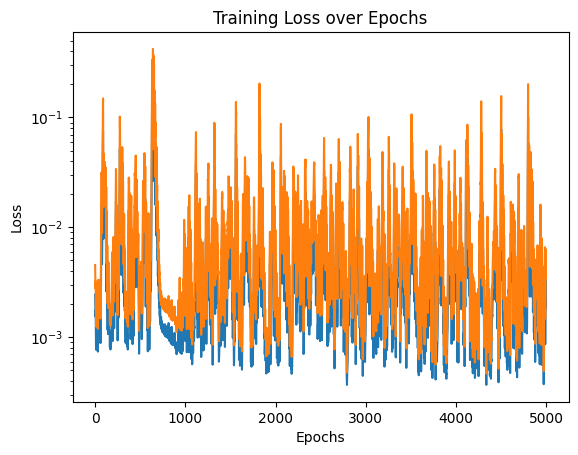

In [85]:
#plot the loss 
import matplotlib.pyplot as plt
plt.plot(losess
         )
plt.plot(pde_losses)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

### now training is done , next is to visualize the results


In [92]:
#VISUALIZATION
def visualize_solution(model,grid_size : int = 50):
    model.eval()
    device = next(model.parameters()).device
    x = np.linspace(0,1,grid_size)
    y = np.linspace(0,1,grid_size)
    X,Y = np.meshgrid(x,y)
    pts = np.stack([X.flatten(),Y.flatten()],axis=1)
    pts_tensor = torch.tensor(pts,dtype=torch.float32).to(device=device)
    with torch.no_grad():
        u_pred = model(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
        u_true = true_solution(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
    
    fig = plt.figure(figsize=(18,6))
    
    ax1 = fig.add_subplot(1,3,1,projection='3d')
    ax1.plot_surface(X,Y,u_true,cmap='viridis')
    ax1.set_title('True Solution')
    
    ax2 = fig.add_subplot(1,3,2,projection='3d')
    ax2.plot_surface(X,Y,u_pred,cmap='viridis')
    ax2.set_title('Predicted Solution')
    
    ax3 = fig.add_subplot(1,3,3,projection='3d')
    ax3.plot_surface(X,Y,np.abs(u_true - u_pred),cmap='viridis')
    ax3.set_title('Absolute Error')
    
    plt.show()

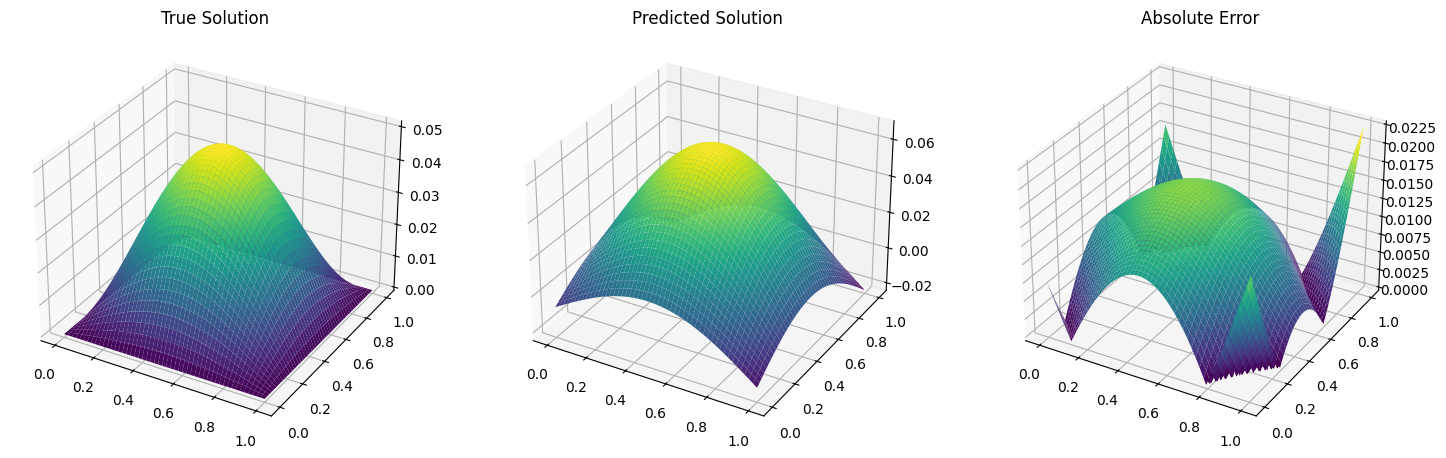

In [93]:
visualize_solution(model,grid_size=1000)

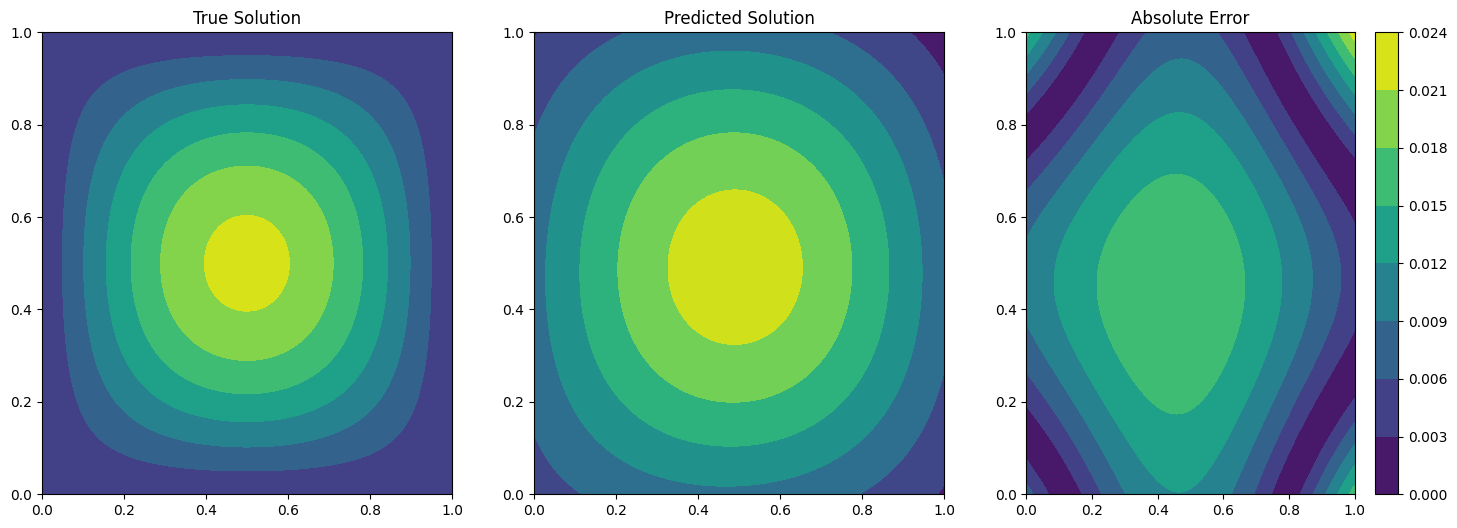

In [101]:
#2d projection visualization
def visualize_solution_2d(model,grid_size : int = 50):
    model.eval()
    device = next(model.parameters()).device
    x = np.linspace(0,1,grid_size)
    y = np.linspace(0,1,grid_size)
    X,Y = np.meshgrid(x,y)
    pts = np.stack([X.flatten(),Y.flatten()],axis=1)
    pts_tensor = torch.tensor(pts,dtype=torch.float32).to(device=device)
    with torch.no_grad():
        u_pred = model(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
        u_true = true_solution(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
    
    fig = plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(1,3,1)
    ax1.contourf(X,Y,u_true,cmap='viridis')
    ax1.set_title('True Solution')
    ax2 = fig.add_subplot(1,3,2)
    ax2.contourf(X,Y,u_pred,cmap='viridis')
    ax2.set_title('Predicted Solution')
    ax3 = fig.add_subplot(1,3,3)
    ax3.contourf(X,Y,np.abs(u_true - u_pred),cmap='viridis')
    ax3.set_title('Absolute Error')
    # add the colorbar
    fig.colorbar(ax3.contourf(X,Y,np.abs(u_true - u_pred),cmap='viridis'), ax=ax3) 
    plt.show()
visualize_solution_2d(model,grid_size=500)